# 一. 重返泰坦尼克号

本次数据分析的对象是泰坦尼克号数据，包括泰坦尼克号上2224名乘客和船员中891名的人口学数据和乘客基本信息，由Kaggle网站提供。下表中展示了前5条数据的基本情况：

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_df = pd.read_csv('titanic-data.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


每个乘客包含12项基本信息：

1. PassengerId：乘客唯一ID
2. Survived：是否生还，0表示遇难，1表示生还
3. Pclass：客舱等级，1表示头等舱，2表示二等舱，3表示下等舱
4. Name：乘客姓名
5. Sex：性别，男（male）或女（female）
6. Age：年龄
7. SibSp：同在船上的兄弟姐妹/配偶数量
8. Parch：同在船上的双亲/子女数量
9. Ticket：票号
10. Fare：船票票价
11. Cabin：客舱号
12. Embarked：登船港口，C = Cherbourg, Q = Queenstown, S = Southampton

从表格中展示的基本情况可以看出，有一部分乘客的客舱号数据已经遗失（NaN）。另外根据Kaggle上的说明，乘客的年龄为浮点数，小于1岁的乘客年龄为分数，如果不知道确切年龄，那么乘客的年龄格式为xx.5。sibsp数据忽略了未婚夫/未婚妻关系，parch数据包括了继子/继女关系，一些儿童乘客是跟保姆一起坐船的，对他们而言parch=0。

# 二. 感兴趣的问题

对于泰坦尼克号数据，我所感兴趣的问题是：

1. 乘客汇总统计信息和总体生还情况是怎样的？
2. 乘客的年龄分布大致情况，最大年龄和最小年龄是多少？他们是否生还？
3. 不同年龄段乘客的生还情况和平均船票花费分别是怎样的？（年龄与生还率之间的关系）
4. 不同客舱等级乘客的生还情况和平均船票花费分别是怎样的？（客舱等级与生还率之间的关系）
5. 不同性别乘客的生还情况和平均船票花费分别是怎样的？（性别与生还率之间的关系）
6. 有多少乘客是带着兄弟姐妹/配偶一同登船的？他们的平均年龄是多少？生还情况如何？（兄弟姐妹/配偶数量与生还率之间的关系）
7. 进一步看，带着兄弟姐妹/配偶的男性乘客和带着兄弟姐妹/配偶的女性乘客各自的生还情况分别是怎样的？
8. 有多少乘客是带着双亲/子女一同登船的？他们的平均年龄是多少？生还情况如何？（双亲/子女数量与生还率之间的关系）
9. 带着双亲/子女的男性乘客和带着双亲/子女的女性乘客生还情况分别是怎样的？
10. 有多少儿童乘客（0~15周岁）？性别分布情况如何？他们的生还情况如何？
11. 有多少儿童乘客是带着父母一同登船的？他们的生还情况如何？
12. 有多少儿童乘客是跟着保姆一起登船的？他们的生还情况如何？
13. 登船的港口和生还率之间会不会存在一定相关性？

# 三. 对数据进行整理

In [18]:
# check whether number of rows and unique number of passengers match
num_of_rows = len(titanic_df['PassengerId'])
num_of_uniq = len(titanic_df['PassengerId'].unique())
print('# of rows: {}; # of unique passengers: {}\n'.format(num_of_rows, num_of_uniq))

print('investigate the missing data of each columns:')
missing = titanic_df.isnull().sum()
ratio = titanic_df.isnull().sum() / len(titanic_df)
round_ratio = ratio.apply(lambda x: str(round(x, 4) * 100) + '%')
print(pd.concat([missing.rename('missing'), round_ratio.rename('percentage(%)')], axis='columns'))

print('\ninvestigating Pclass')
print(titanic_df.groupby('Pclass').groups.keys())

print('\ninvestigating Sex')
print(titanic_df.groupby('Sex').groups.keys())

print('\ninvestigating Embarked')
print(titanic_df.groupby('Embarked').groups.keys())

# of rows: 891; # of unique passengers: 891

investigate the missing data of each columns:
             missing percentage(%)
PassengerId        0          0.0%
Survived           0          0.0%
Pclass             0          0.0%
Name               0          0.0%
Sex                0          0.0%
Age              177        19.87%
SibSp              0          0.0%
Parch              0          0.0%
Ticket             0          0.0%
Fare               0          0.0%
Cabin            687         77.1%
Embarked           2         0.22%

investigating Pclass
[1, 2, 3]

investigating Sex
['male', 'female']

investigating Embarked
['Q', 'C', 'S']


从以上对数据的初步调查可以看出，数据集的行数与乘客的数量相等，也就是说**不存在重复的数据**。然而年龄、客舱和登船港口数据存在缺失。有177名乘客的年龄数据缺失，占比19.87%，那么**在进行针对年龄的数据分析时必须把这部分数据筛除，否则势必影响结论的可靠性**；有687项数据缺失了客舱信息，占比77.1%，是数据缺失的重灾区，好在这对后面要进行的数据分析不存在影响：我们只需要知道客舱的等级就好，不需要知道具体客舱号，客舱等级数据不存在缺失。登陆港口只有两项数据是缺失的，占比不大，因此对结论的影响较小。最后，检查了一下客舱等级，性别和登陆港口数据，因为这些数据是有限取值范围的枚举值，检查下有没有错误数据，**结论是没有**。

In [25]:
titanic_df_age = titanic_df[pd.notnull(titanic_df['Age'])].drop('Cabin', axis=1)
titanic_df_embark = titanic_df[pd.notnull(titanic_df['Embarked'])].drop('Cabin', axis=1)
print('valid age {}, valid embark {}'.format(len(titanic_df_age), len(titanic_df_embark)))
display(titanic_df_age.head())
display(titanic_df_embark.head())

valid age 714, valid embark 889


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


为方便后面的分析工作，我们对数据进行了清洗。对于后面要进行的有关乘客年龄的数据分析，我们将缺失数据滤除，对登陆港口也做同样处理，由于只需要知道客舱等级而不再需要客舱号，因此顺便将客舱号这列删除。最后打印了一下清洗后的数据进行观察，跟预期的一致，没有问题。

# 四. 数据分析

In [31]:
display(titanic_df.describe())
sum_of_survived = titanic_df['Survived'].sum()
survived_ratio = round(sum_of_survived / float(len(titanic_df)), 4) * 100
print('number of passengers survived {} about {}%'.format(titanic_df['Survived'].sum(), survived_ratio))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


number of passengers survived 342 about 38.38%


## 1. 乘客汇总统计信息和总体生还情况

891名乘客平均年龄约29.70周岁，标准差为14.53，表明年龄分布较为分散，最大年龄乘客80岁，最小的不足1岁；有乘客最多带了8位家属（兄弟姐妹/配偶）登船，还有的乘客最多带了6位直系血亲（父母/子女）登船；这些乘客购买船票平均花费了约32.20货币单位，标准差49.69，表明不同乘客的船票开销差异较大。891人中仅342人生还，总体生还率约38.38%。

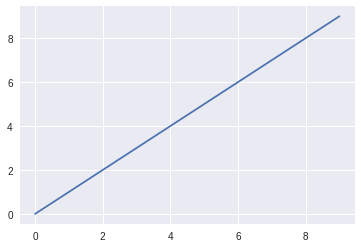

In [34]:
plot(np.arange(10))

## 2. 乘客的年龄分布大致情况，最大年龄和最小年龄的生还情况是怎样的？

3. 不同年龄段乘客的生还情况和平均船票花费分别是怎样的？（年龄与生还率之间的关系）
4. 不同客舱等级乘客的生还情况和平均船票花费分别是怎样的？（客舱等级与生还率之间的关系）
5. 不同性别乘客的生还情况和平均船票花费分别是怎样的？（性别与生还率之间的关系）
6. 有多少乘客是带着兄弟/配偶一同登船的？他们的平均年龄是多少？生还情况如何？（兄弟/配偶数量与生还率之间的关系）
7. 进一步看，带着兄弟/配偶的男性乘客和带着兄弟/配偶的女性乘客各自的生还情况分别是怎样的？
8. 有多少乘客是带着双亲/子女一同登船的？他们的平均年龄是多少？生还情况如何？（双亲/子女数量与生还率之间的关系）
9. 带着双亲/子女的男性乘客和带着双亲/子女的女性乘客生还情况分别是怎样的？
10. 有多少儿童乘客（0~15周岁）？性别分布情况如何？他们的生还情况如何？
11. 有多少儿童乘客是带着父母一同登船的？他们的生还情况如何？
12. 有多少儿童乘客是跟着保姆一起登船的？他们的生还情况如何？
13. 登船的港口和生还率之间会不会存在一定相关性？

四. 探索数据

1. 一维数据分析

2. 二维数据分析

五. 得出结论

要表明结论只是暂时的

六. 沟通阶段

七. 评分标准

代码功能性

代码是否正常运行？所有代码均有用且运行时不会产生错误。所给代码足够重现描述的结果。

项目是否适当使用了 NumPy 和 Pandas？项目在适当情况下使用 NumPy 阵列和 Pandas 系列及 DataFrames，而非 Python 列表与字典。并在可能情况下使用矢量化操作和内置函数，而非循环。

项目是否使用良好的编码实践？代码利用函数来避免重复代码。代码包含清晰的注释和变量名称，可读性较高。

分析质量
项目是否清楚地提出了问题？项目清楚地提出了一个或多个问题，然后在分析的其余部分解决了这些问题。

数据整理阶段
是否对数据清理进行了良好的记录？项目记录了为清理数据所做的所有变更，例如合并多个文件，处理丢失的值等。

探索阶段
是否采用多种方式探索数据？项目从多个角度调查所述问题。至少有三个变量使用单变量 (1d) 和多变量 (2d) 探索进行了调查。

是否存在多种相关可视化和统计汇总？项目采用了多种可视化并展示了多项对比和趋势。分析中在进行与数据有关的推理时都会计算相关统计。至少应创建两种图作为探索的部分。

结论阶段
学员是否正确表明了结论只是暂时的？分析结果在展示时明确说明了存在的任何限制。分析并未表明或暗示一个变更完全基于相关性导致另一个变更。

沟通阶段
分析流程是否容易理解？每个分析决策、图和统计汇总均提供了推理说明。

数据是否使用了适当的图和参数进行了可视化？项目的可视化采用适当的方式描述数据，所用的图容易解读。